# An Introduction to Nipype

## Goals

1. Give a brief introduction to the nipype API.
2. Demonstrate how to create nodes and workflows.
3. Execute a simple workflow.
4. Inspect the outputs.

## Preliminary

The simplest way of thinking about nipype is as an interface (or set of interfaces) that allow all of our favourite neuroimaging packages to talk to one another and work effectively together.

## A Minimal example: Slice-timing correction in FSL

Let's suppose that we wanted to perform a fairly common task, like slice-timing in FSL. How would we do this in nipype?

As a first step, we would refer to the relevant nipype documentation, which gives us a brief example of how to do this, and lists a set of inputs and outputs.

https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.fsl.preprocess.html#slicetimer

This reference should be considered your **bible** that you consult for guidance about how to run virtually any process within the nipype framework. There are sub-sections for interfaces for [AFNI](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.afni.preprocess.html),[ANTS](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.ants.registration.html) [SPM](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.spm.preprocess.html)  etc....

We won't copy their example verbatum, but we will include our own example data.

In [3]:
# First we import the necessary modules. This includes the fsl interface.

from nipype.interfaces import fsl
from nipype.testing import example_data

# Next, we indicate the  specific function we are using from that interface.

st = fsl.SliceTimer()

# We then define inputs to this function, including the directory of the 
st.inputs.in_file = '/media/nicholas/STORE/examp/bold.nii.gz'
st.inputs.interleaved = True

200409-13:32:33,339 nipype.utils INFO:
	 Running nipype version 1.3.2 (latest: 1.4.2)


Now, I am going to add some flavour to this. I am going to specify exactly where I want the output file to be stored and I am also going to specify the repetition time. 

In [4]:
st.inputs.out_file = '/media/nicholas/STORE/examp/bold_slicetime.nii.gz'
st.inputs.time_repetition=1.5

Essentially, what nipype does is take these options, translate them and pass them to the command line. We can query what information is being sent to the command line as follows:

In [126]:
st.cmdline

u'slicetimer --in=/media/nicholas/STORE/examp/bold.nii.gz --odd --out=/media/nicholas/STORE/examp/bold_slicetime.nii.gz --repeat=1.500000'

Now, all that remains is to run the slicetimer, as follows.

In [127]:
st.run()

As a general rule, I reccommend trying to inspect the outputs of each process that you run. Its nice if you are able to do this within python itself, to save you having to open up fslview or something like that.

Here, I am going to do this using a combination of nilearn and nibabel. Don't break your head on what is happening below too much, as I plan to go over these packages in later notebooks.

All you need to know for now is that I am defining a function for plotting data from each slice before and after the slicetiming correction in order to take a look at the temporal shifts that have been applied.

In [10]:
def tshiftplot(pre_file, post_file,axis,size_x,size_y, extent):
    
    
    # Function goal: To produce a plot that allows visualisation of temporal shifts performed by slice-timing.
    
    # Detail: Plots the "middle" voxel for each slice along the relevant axis.
    
    #Inputs
    
    # pre-file (the file before slice-timing)
    # post_file (the file after slice timing)
    # Axis (the axis along which slice timing correction was applied (usually z) x= 0, y =1, z =2)
    # sizex, sizey (plotting size)
    # extent (the number of datapoints to plot (starts at 0))
    
    # Note that this assumes the data have put into a standard orientation using something like fslreorient2std.
    
    
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    import matplotlib
    import numpy as np
    import nibabel as nib
    
    dims=range(3)
    dims.remove(axis)
    
    img1=nib.load(pre_file)
    data=img1.get_data()
    img2=nib.load(post_file)
    data2=img2.get_data()
    fig, ax = plt.subplots(figsize=(size_x, size_y))
    
    mid1=int(round(data.shape[dims[0]]/2))
    mid2=int(round(data.shape[dims[1]]/2))
    
    slices=range(data.shape[axis])
    for i in slices:
        for j in range(1):
            ax = plt.subplot2grid((data.shape[axis],1), (i,j))
            ax.plot(data[mid1,mid2,i,0:extent],'ro',alpha=.6)
            ax.plot(data[mid1,mid2,i,0:extent],'r-')
            ax.plot(data2[mid1,mid2,i,0:extent],'g^',alpha=.6)
            ax.plot(data2[mid1,mid2,i,0:extent],'g-')
            ax.yaxis.set_visible(False)
            ax.set_xticks(np.arange(0, extent+1, 1.0))
            
            
    green_patch = mpatches.Patch(color='green', label='The shifted data')
    legend2=plt.legend(handles=[green_patch],loc=1)
    plt.gca().add_artist(legend2)
    red_patch = mpatches.Patch(color='red', label='The original data')
    plt.legend(handles=[red_patch],loc=2)
    plt.show()

Now I plot some data from each slice. Here, I have some way of verifying that some kind of temporal shift has taken place 

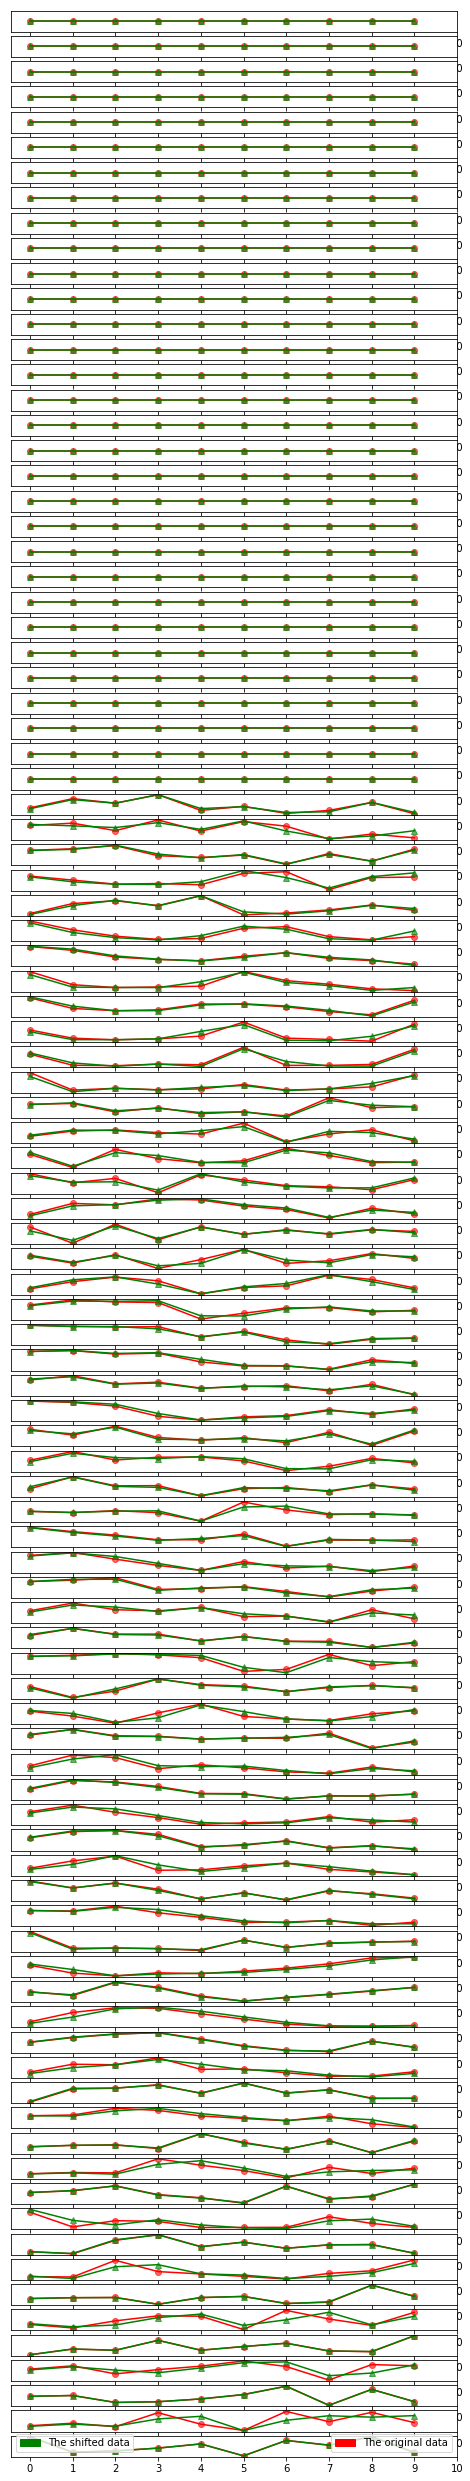

In [9]:
tshiftplot(st.inputs.in_file,st.inputs.out_file,2,8,45,10)

Plotted here are some data from each slice before and after the slicetiming operation.  

# A Minimal example: A Simple Pipeline.

The real power of nipype isn't simply calling external functions from within python.

Instead, nipype provides a simple method for connecting these functions together, into something called a **workflow**.

Lets say, for instance, that I want to

i) Perform slice-timing correction with FSL,
ii) then I want to  smooth, extract and detrend the data using AFNI.

This would be a bit of a pain ordinarily, as we would need to switch between these programs. In nipype this is simplified - as we simply need to define a *workflow* that connects all these functions together.

Below I give an annotated example of this. 


### 1. We define nodes and the inputs to these nodes.

Nodes are essentially self-contained functions, such as the slice timing operation we just performed.

Here I add a set of nodes for performing the various tasks I mentioned above. I have annotated.

In [57]:
from nipype.interfaces import afni as afni
from nipype.interfaces import fsl as fsl
import nipype.interfaces.utility as util 
import nipype.pipeline.engine as pe


# Node 1, slicetiming correction using FSL
st=pe.Node(interface=fsl.SliceTimer(),name='slicetime')

# Define the inputs
st.inputs.in_file = '/media/nicholas/STORE/examp/bold.nii.gz'
st.inputs.interleaved = True
st.inputs.time_repetition=1.5

# Node 2, simultaneous smoothing and brain extraction using AFNI
bim=pe.Node(interface=afni.BlurInMask(),name='smooth')
# Define the inputs
bim.inputs.mask = '/media/nicholas/STORE/examp/bold_mask.nii.gz' # I give the path to the brain mask.
bim.inputs.fwhm = 3.0 # I want 3mm smoothing. 
bim.inputs.outputtype= 'NIFTI_GZ'

# Node 3, detrending using AFNI.
dt = pe.Node(interface=afni.Detrend(),name='detrend')                     
dt.inputs.args = '-polort 3' # I want to remove polynomials up to an order of 3. 
dt.inputs.outputtype= 'NIFTI_GZ'

# Node 4 & 5. AFNI will remove the mean from the data as part of the detrending. We dont want this and so
# we use FSL maths operations to calculate a mean before detrending the image and then we add this back in
# after detrending.

meanfunc = pe.Node(interface=fsl.ImageMaths(),name='MEANVOL')
meanfunc.inputs.op_string='-Tmean' # I want to send the command to calculate the mean.


addmean = pe.Node(interface=fsl.BinaryMaths(),name='RE_ADD_MEAN')
addmean.inputs.operation='add' # I want to send the command to add two volumes together.


### 2. Now we name our workflow and define a directory where the outputs will be stored.

In [58]:
workflow = pe.Workflow(name='MYWORKFLOW')
workflow.base_dir = '/media/nicholas/STORE/examp/'

### 3. Now we connect our nodes together

In [59]:
# We connect the output of the slicetiming node and make this the input to the smoothing node.
workflow.connect(st, 'slice_time_corrected_file', bim, 'in_file')

# We connect the output of the smoothing node, and connnect this to the detrend node.
workflow.connect(bim, 'out_file', dt, 'in_file')

# We connect the output of the detrend node, and connnect this to meanfunc node.
workflow.connect(bim, 'out_file', meanfunc, 'in_file')

# We connect the output of the detrend node, and connnect this to the addmean node
workflow.connect(dt, 'out_file', addmean, 'in_file')

# We connect the output of the detrend node, and connnect this to the addmean node

workflow.connect(meanfunc, 'out_file', addmean, 'operand_file')

It seems quite hard to understand exactly what is happening here. Fortunately, nipype allows us to view everything as a graph. We can write the graph with the following command.

In [60]:
workflow.write_graph(graph2use='exec')

200409-15:28:34,265 nipype.workflow INFO:
	 Generated workflow graph: /media/nicholas/STORE/examp/MYWORKFLOW/graph.png (graph2use=exec, simple_form=True).


u'/media/nicholas/STORE/examp/MYWORKFLOW/graph.png'

Let's look at the graph. 

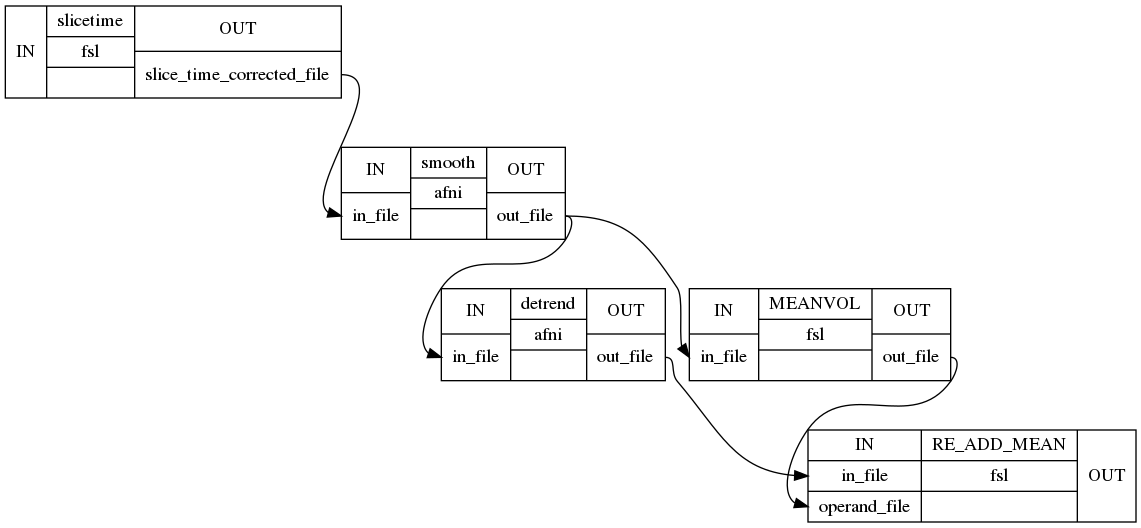

In [61]:
from IPython.display import Image
import os

Image(filename=os.path.join(workflow.base_dir,workflow.name,'graph_detailed.png'))

So, to recap:

1. We first perform slicetiming with fsl,
2. We then smooth and extract the non brain tissue with AFNI, using the 3Dblurinmask command.
3. Before detrending, we calculate a mean volume using fsl maths, which we then add back onto the detrended data.

Now we have checked our workflow, all that is left is to..

### 4. Run the workflow.

We will recieve progress messages as the workflow executes. It is worth reading these, just so you have some idea of what is going on under the hood.

In [62]:
result=workflow.run()

200409-15:28:58,397 nipype.workflow INFO:
	 Workflow MYWORKFLOW settings: ['check', 'execution', 'logging', 'monitoring']
200409-15:28:58,403 nipype.workflow INFO:
	 Running serially.
200409-15:28:58,405 nipype.workflow INFO:
	 [Node] Setting-up "MYWORKFLOW.slicetime" in "/media/nicholas/STORE/examp/MYWORKFLOW/slicetime".
200409-15:28:58,409 nipype.workflow INFO:
	 [Node] Running "slicetime" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/media/nicholas/STORE/examp/bold.nii.gz --odd --out=/media/nicholas/STORE/examp/MYWORKFLOW/slicetime/bold_st.nii.gz --repeat=1.500000
200409-15:29:27,500 nipype.workflow INFO:
	 [Node] Finished "MYWORKFLOW.slicetime".
200409-15:29:27,502 nipype.workflow INFO:
	 [Node] Setting-up "MYWORKFLOW.smooth" in "/media/nicholas/STORE/examp/MYWORKFLOW/smooth".
200409-15:29:27,510 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.afni.preprocess.BlurInMask"), a CommandLine Interface with com

Splendid, it seems as though our workflow executed cleanly.

### 5. Inspect the outputs of the workflow

Below I define a function for recursively printing the contents of our base directory.

When I run this, we can see that a subfolder has been created for each of our nodes. For instance /MEANVOL contains the mean volume, /smooth contains the smoothed volume and so on. 

In [124]:
def list_files(startpath):
    
    # Function goal: To print a directory structure.
    
    # Detail: Will walk within the sub directories and print the outputs
    
    #Inputs
    
    # startpath (the directory to print)
    
    
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

# Now print the outputs of our workflow directory
list_files(os.path.join(workflow.base_dir,workflow.name))

MYWORKFLOW/
    d3.js
    graph1.json
    graph.json
    index.html
    MEANVOL/
        result_MEANVOL.pklz
        bold_st_blur_maths.nii.gz
        _0x9953695d1fc5c2984e74b90030b1ca94.json
        _node.pklz
        _inputs.pklz
        command.txt
        _report/
            report.rst
    RE_ADD_MEAN/
        _0x4ebd919ae0138e169b57d52c51597c81.json
        result_RE_ADD_MEAN.pklz
        _node.pklz
        bold_st_blur_detrend_maths.nii.gz
        _inputs.pklz
        command.txt
        _report/
            report.rst
    smooth/
        bold_st_blur.nii.gz
        _0x498b0da7a657294267103c8cd4707cca.json
        result_smooth.pklz
        _node.pklz
        _inputs.pklz
        command.txt
        _report/
            report.rst
    detrend/
        result_detrend.pklz
        bold_st_blur_detrend.nii.gz
        _node.pklz
        _inputs.pklz
        _0x8e74e6d98f645eaa430c2b043600d57b.json
        command.txt
        _report/
            report.rst
    slicetime/
        bol

I want to perform some sanity checks to make sure that the workflow did what we though it did.

Therefore, I first want to plot the data before and after the smoothing took place. To do this, I first define a function for plotting before and after this node executed.

In [190]:
def ba_bim(pre_file,post_file,slices):
    
    # Function goal: To plot functional data before and after a call to 'blur in mask'
    
    # Detail: Slices in the z dimension.
    
    #Inputs
    
    # pre_file (file before command)
    # post_file (file after command)
    # slices (Number of slices)
    
    
    from nilearn import image
    from nilearn import plotting
    import matplotlib
    b=1
    # Plot just the first volume
    pre_im=image.index_img(pre_file,0)
    display=plotting.plot_anat(pre_im,title="Before bim",display_mode='z', cut_coords=slices)
    matplotlib.pyplot.show()
    post_im=image.index_img(post_file, 0)
    display2=plotting.plot_anat(post_im,display_mode='z', cut_coords=slices,title="After bim")
    matplotlib.pyplot.show()
    return b

Now I define a function for finding nifti files.

In [126]:
def findniftis(FOLDER,ext):
    
    # Function goal: return nifti files within a directory
    
    # Detail: could be used for a file with any extension...
    
    #Inputs
    
    # FOLDER (directory to search)
    # ext (the suffix (.nii or .nii.gz))
    
    def fprintf(stream, format_spec, *args):
        stream.write(format_spec % args)
    import os
    import sys
    niftilist=list()
    for file in os.listdir(FOLDER):
        if file.endswith(ext):
            niftilist.append(FOLDER+"/"+file)
    fprintf(sys.stdout, "Found %d nifti files \n", len(niftilist))
    return(sorted(niftilist))

Now I get the nifti files from the relevant folders (before and after the smoothing).

In [119]:
b_smooth=findniftis(os.path.join(workflow.base_dir,workflow.name,'slicetime'),'.nii.gz') # Slicetiming is before smooothing
a_smooth=findniftis(os.path.join(workflow.base_dir,workflow.name,'smooth'),'.nii.gz') # after the smoothing

Found 1 nifti files 
Found 1 nifti files 


Finally, I plot the data before and after the smoothing. 

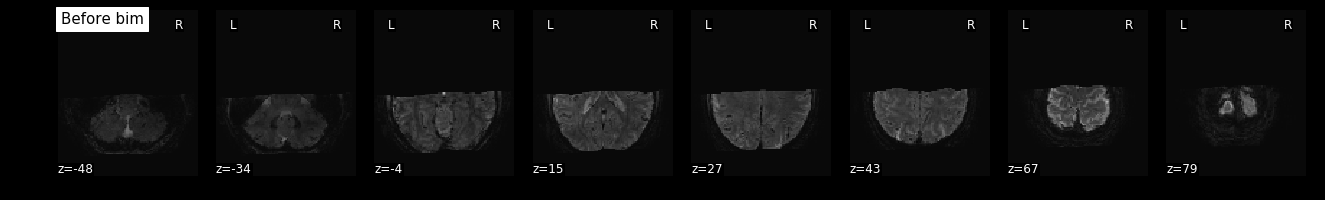

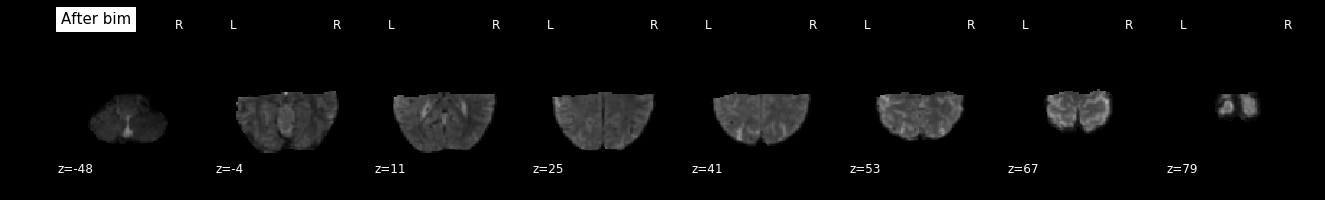

In [120]:
ba_bim(b_smooth[0],a_smooth[0],8)

It seems as though the node has done a good job at both smoothing and removing nonbrain tissue.

As a next exercise, I want to try and visualise what the detrend node has done. 

Again, I first define a very simple function for doing this.

In [132]:
def ba_detrend(pre_file,post_file,coord,sizex,sizey):
    
    # Function goal: To produce a plot that allows visualisation of data before and after detrending.
    
    # Detail: For simplicity we only plot one voxels data
    
    #Inputs
    
    # pre-file (the file before detrending)
    # post_file (the file after detrending)
    # coord (the coordinates of the voxel to be plotted)
    # sizex, sizey (plotting size)
    
    import nibabel as nib
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    x=coord[0]
    y=coord[1]
    z=coord[2]
    img1=nib.load(pre_file)
    data=img1.get_data()
    img2=nib.load(post_file)
    data2=img2.get_data()
    plt.figure(constrained_layout=True,figsize=(sizex,sizey))
    plt.plot(data[x,y,z,:],'ro',alpha=.6)
    plt.plot(data[x,y,z,:],'r-')
    plt.plot(data2[x,y,z,:],'g^',alpha=.6)
    plt.plot(data2[x,y,z,:],'g-')
    green_patch = mpatches.Patch(color='green', label='The detrended data')
    legend2=plt.legend(handles=[green_patch],loc=1)
    plt.gca().add_artist(legend2)
    red_patch = mpatches.Patch(color='red', label='The original data')
    legend1=plt.legend(handles=[red_patch],loc=2)
    return display

I then recover the files that were created before and after the detrending process.

In [110]:
b_detrend=findniftis(os.path.join(workflow.base_dir,workflow.name,'smooth'),'.nii.gz') # smoothing happened before detrending
a_detrend=findniftis(os.path.join(workflow.base_dir,workflow.name,'RE_ADD_MEAN'),'.nii.gz') # after detrending

Found 1 nifti files 
Found 1 nifti files 


I'm specifically going to plot data from a voxel that I know had some quite bad linear drift before detrending.

<function IPython.core.display.display>

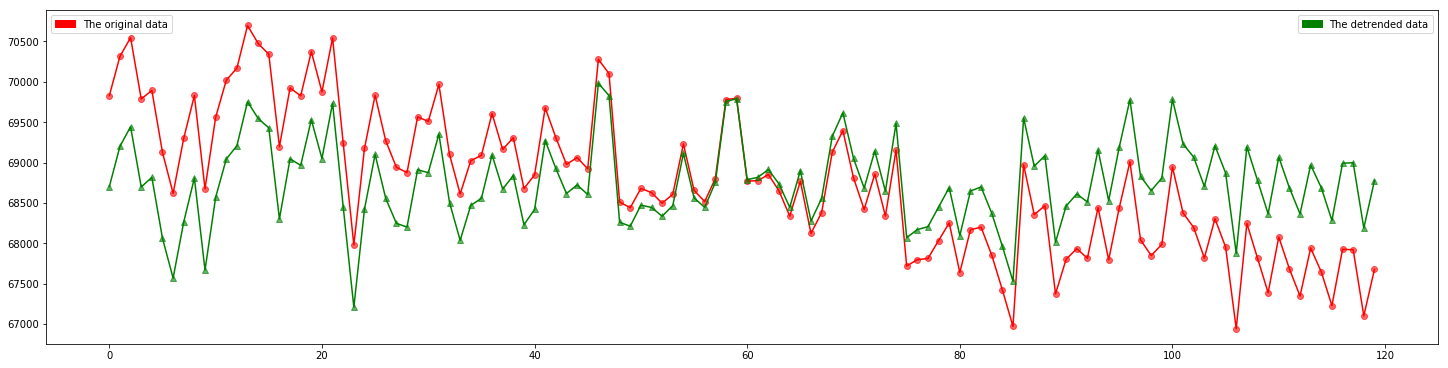

In [133]:
ba_detrend(b_detrend[0],a_detrend[0],[40,50,68],20,5)

Here we can see that the detrending has successfully removed the linear drift from the signal. Good.

# A Minimal example: Introducing Iterables and the utility & function interfaces.

One strength of the nipype framework is that it is trivially simple to implement loops. 

For instance, lets suppose that I wanted to perform smoothing, but I was unsure about the size of the smoothing kernel I wanted to implement. One solution to this would be to simply apply a great many smoothing kernels.

I am going to create a very simple workflow to illustrate this. First I want to define an **input node**, this is just a convenient way of defining our inputs all in one place within the workflow.

We can then connect the input node to the relevant places downstream.

In [212]:
import nipype.interfaces.utility as util 

inputnode = pe.Node(interface=util.IdentityInterface(fields=['file','mask','slices','outputtype','fwhm']),name='inputspec')

inputnode.inputs.file = '/media/nicholas/STORE/examp/bold.nii.gz'
inputnode.inputs.mask = '/media/nicholas/STORE/examp/bold_mask.nii.gz' # I give the path to the brain mask.
inputnode.inputs.outputtype= 'NIFTI_GZ'
inputnode.inputs.slices= int(8)

Now I define the smoothing kernel widths I would like to iterate over (3, 6 and 10 mm). I put these into a list.

In [213]:
widths=[3,6,10]

Now I define fwhm as an **iterable**, as follows.

As the name suggests, this ensures that these values will be iterated over.

In [214]:
inputnode.iterables=([('fwhm',widths)])

Now we define the smoothing node. 

In [215]:
bim2=pe.Node(interface=afni.BlurInMask(),name='smooth2',iterfield=['fwhm'])

One thing that may have occured to you at this point is that my way of inspecting the outputs of the previous workflow *post-hoc* was a little sloppy.

Fortunately, we can integrate our own functions into the workflow directly as follows, via the **function interface**.

Here, I feed in my function for viewing the volume before and after smoothing.

In [216]:
from nipype.interfaces.utility import Function

showsmooth= pe.Node(Function(input_names=['pre_file','post_file','slices'],output_names=['display'],function=ba_bim),name='SHOWSMOOTH')

I now want to define this as workflow 2.

In [220]:
workflow2 = pe.Workflow(name='MYWORKFLOW2')
workflow2.base_dir = '/media/nicholas/STORE/examp/'

And I connect the nodes.

In [221]:
# Connect the input node to the relevant places
workflow2.connect(inputnode, 'file', bim2, 'in_file')
workflow2.connect(inputnode, 'mask', bim2, 'mask')
workflow2.connect(inputnode, 'fwhm', bim2, 'fwhm')
workflow2.connect(inputnode,'outputtype',bim2,'outputtype')
workflow2.connect(inputnode, 'slices', showsmooth, 'slices')
workflow2.connect(inputnode, 'file', showsmooth, 'pre_file')

# Connect the smoothing node to the plotting node.
workflow2.connect(bim2, 'out_file', showsmooth, 'post_file')

Now let's plot the workflow again, using a slightly different option, so we can view the iterables.

200409-18:02:50,801 nipype.workflow INFO:
	 Generated workflow graph: /media/nicholas/STORE/examp/MYWORKFLOW2/graph.png (graph2use=exec, simple_form=True).


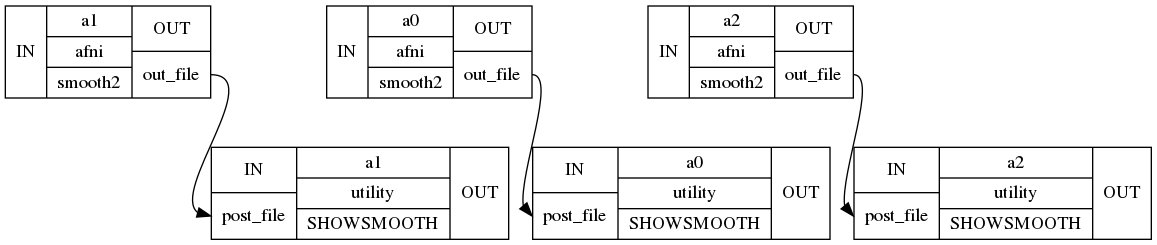

In [222]:
workflow2.write_graph(graph2use='exec')
Image(filename=os.path.join(workflow2.base_dir,workflow2.name,'graph_detailed.png'))

Here we can see that the smoothing node will be executed 3 separate times, corresponding to the 3 seperate kernel widths we asked for.

Accordingly, these will feed into 3 seperate plotting nodes, meaning that we will see 3 outputs in the terminal. 

You may notice that the input node is missing from the plot. We need to generate a slightly different graph for this.

200409-18:04:07,481 nipype.workflow INFO:
	 Generated workflow graph: /media/nicholas/STORE/examp/MYWORKFLOW2/graph.png (graph2use=flat, simple_form=True).


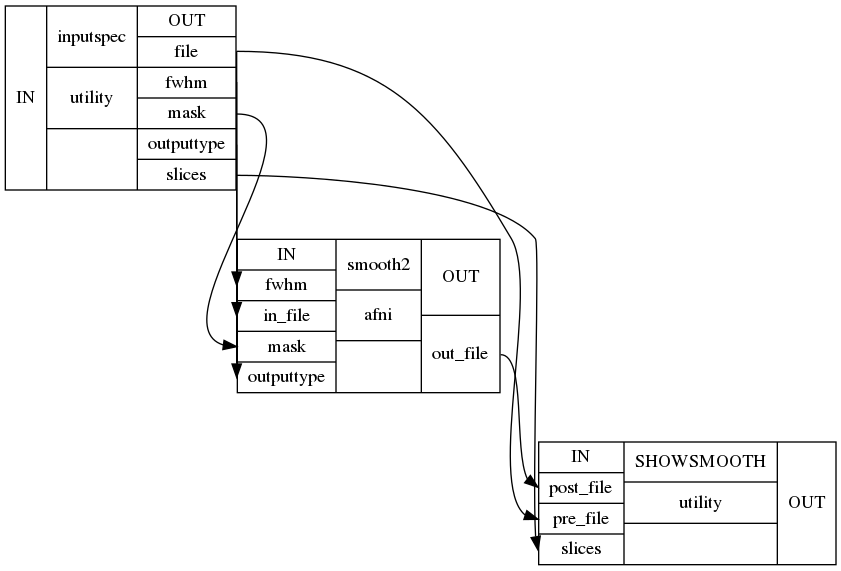

In [223]:
workflow2.write_graph(graph2use='flat')
Image(filename=os.path.join(workflow2.base_dir,workflow2.name,'graph_detailed.png'))

Lovely, so now let's run this workflow. 

200409-18:04:40,192 nipype.workflow INFO:
	 Workflow MYWORKFLOW2 settings: ['check', 'execution', 'logging', 'monitoring']
200409-18:04:40,201 nipype.workflow INFO:
	 Running serially.
200409-18:04:40,203 nipype.workflow INFO:
	 [Node] Setting-up "MYWORKFLOW2.smooth2" in "/media/nicholas/STORE/examp/MYWORKFLOW2/_fwhm_3/smooth2".
200409-18:04:40,208 nipype.workflow INFO:
	 [Node] Running "smooth2" ("nipype.interfaces.afni.preprocess.BlurInMask"), a CommandLine Interface with command:
3dBlurInMask -input /media/nicholas/STORE/examp/MYWORKFLOW2/_fwhm_3/smooth2/bold.nii.gz -FWHM 3.000000 -mask /media/nicholas/STORE/examp/bold_mask.nii.gz -prefix bold_blur.nii.gz
200409-18:04:40,260 nipype.interface INFO:
	 stderr 2020-04-09T18:04:40.260077:++ 3dBlurInMask: AFNI version=Debian-18.0.05+git24-gb25b21054~dfsg.1-1~nd17.10+1+nd18.04+1 (May 17 2018) [64-bit]
200409-18:04:40,263 nipype.interface INFO:
	 stderr 2020-04-09T18:04:40.263282:++ Authored by: RW Cox
200409-18:04:40,282 nipype.interface I

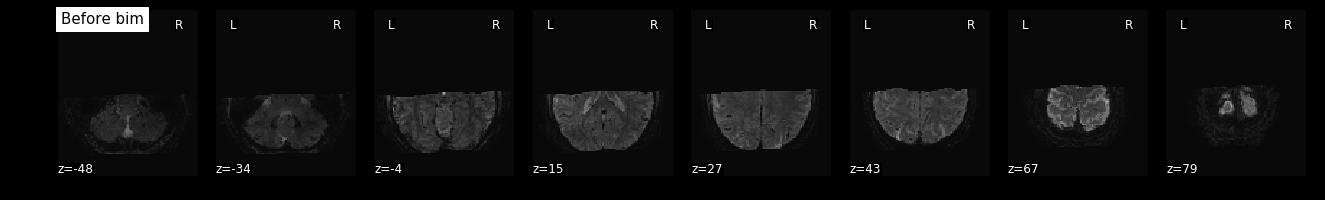

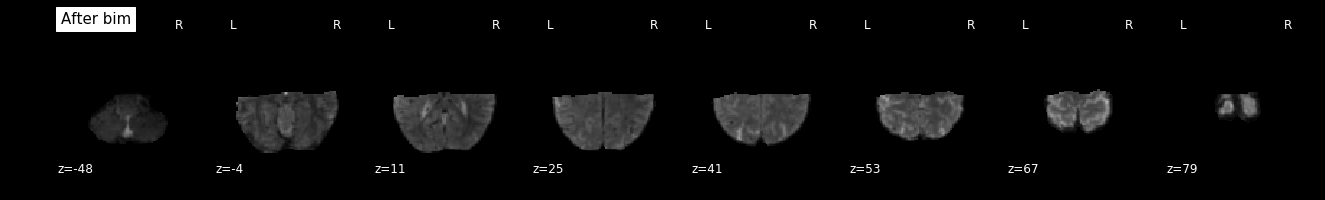

200409-18:04:53,746 nipype.workflow INFO:
	 [Node] Finished "MYWORKFLOW2.SHOWSMOOTH".
200409-18:04:53,747 nipype.workflow INFO:
	 [Node] Setting-up "MYWORKFLOW2.smooth2" in "/media/nicholas/STORE/examp/MYWORKFLOW2/_fwhm_6/smooth2".
200409-18:04:53,752 nipype.workflow INFO:
	 [Node] Running "smooth2" ("nipype.interfaces.afni.preprocess.BlurInMask"), a CommandLine Interface with command:
3dBlurInMask -input /media/nicholas/STORE/examp/MYWORKFLOW2/_fwhm_6/smooth2/bold.nii.gz -FWHM 6.000000 -mask /media/nicholas/STORE/examp/bold_mask.nii.gz -prefix bold_blur.nii.gz
200409-18:04:53,815 nipype.interface INFO:
	 stderr 2020-04-09T18:04:53.814932:++ 3dBlurInMask: AFNI version=Debian-18.0.05+git24-gb25b21054~dfsg.1-1~nd17.10+1+nd18.04+1 (May 17 2018) [64-bit]
200409-18:04:53,817 nipype.interface INFO:
	 stderr 2020-04-09T18:04:53.817547:++ Authored by: RW Cox
200409-18:04:53,834 nipype.interface INFO:
	 stderr 2020-04-09T18:04:53.834873:++ Number of voxels in mask = 138048
200409-18:04:53,836 n

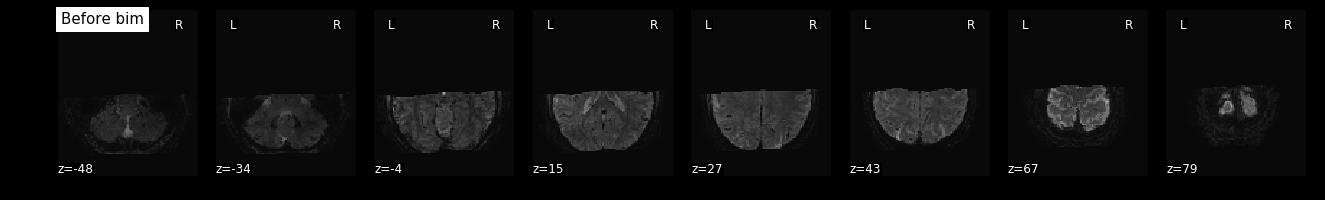

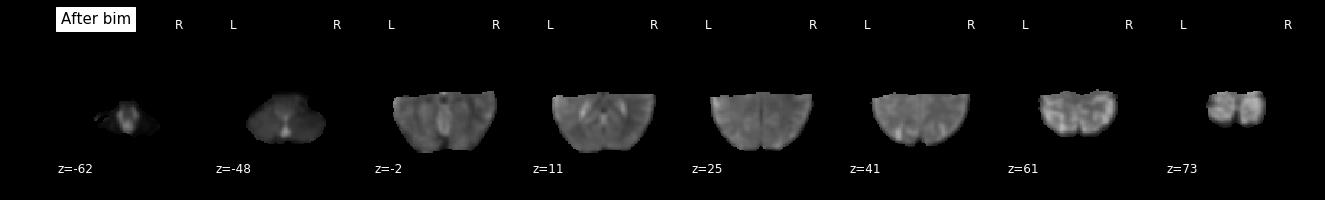

200409-18:05:07,805 nipype.workflow INFO:
	 [Node] Finished "MYWORKFLOW2.SHOWSMOOTH".
200409-18:05:07,807 nipype.workflow INFO:
	 [Node] Setting-up "MYWORKFLOW2.smooth2" in "/media/nicholas/STORE/examp/MYWORKFLOW2/_fwhm_10/smooth2".
200409-18:05:07,812 nipype.workflow INFO:
	 [Node] Running "smooth2" ("nipype.interfaces.afni.preprocess.BlurInMask"), a CommandLine Interface with command:
3dBlurInMask -input /media/nicholas/STORE/examp/MYWORKFLOW2/_fwhm_10/smooth2/bold.nii.gz -FWHM 10.000000 -mask /media/nicholas/STORE/examp/bold_mask.nii.gz -prefix bold_blur.nii.gz
200409-18:05:07,867 nipype.interface INFO:
	 stderr 2020-04-09T18:05:07.867714:++ 3dBlurInMask: AFNI version=Debian-18.0.05+git24-gb25b21054~dfsg.1-1~nd17.10+1+nd18.04+1 (May 17 2018) [64-bit]
200409-18:05:07,869 nipype.interface INFO:
	 stderr 2020-04-09T18:05:07.869553:++ Authored by: RW Cox
200409-18:05:07,892 nipype.interface INFO:
	 stderr 2020-04-09T18:05:07.891894:++ Number of voxels in mask = 138048
200409-18:05:07,89

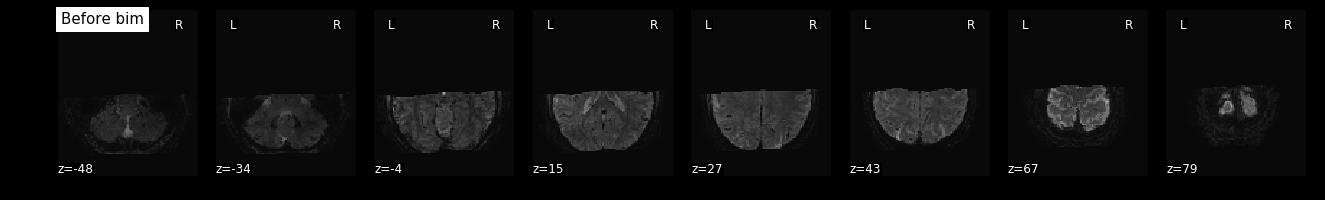

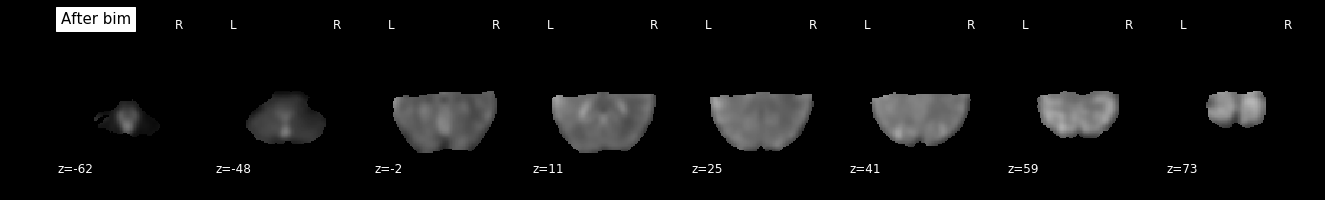

200409-18:05:24,107 nipype.workflow INFO:
	 [Node] Finished "MYWORKFLOW2.SHOWSMOOTH".


In [224]:
workflow2.run()

Cool, so we performed 3 seperate smoothing operations and plotted them on the fly.